```{contents}
:local:
:depth: 2
```

# Linear Regression

## Learning Objectives

After completing this lecture, students should be able to:

- Define simple, polynomial, and general linear regression models.
- Derive the least squares solution using matrix calculus.
- Construct basis function matrices (e.g., Vandermonde, Gaussian).
- Fit models using both manual matrix operations and `scikit-learn`.
- Interpret model outputs and assess fit quality visually and numerically.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt  # standard and recommended import convention
import numpy as np
plt.style.use('../settings/plot_style.mplstyle')

## Simple linear regression

Linear regression is a great starting point for understanding how linear algebra and optimization are used together for data analytics. We will start with simple linear regression, which you should be familiar with.

The form of a simple linear regression model is given as:

$$
y = m x + b + \epsilon
$$

where $y$ is the independent variable, $x$ is the dependent variable, $m$ is the slope of the line, $b$ is the intercept, and $\epsilon$ is the error between the model and the actual data. This can also be written with indices on the data:

$$
y_i = m x_i + b + \epsilon_i
$$

where $i$ refers to the index of the data point (e.g., the first, second, third, ... data point). We can also think of these quantities as vectors:

$$
\vec{y} = m\vec{x} + b + \vec{\epsilon}
$$

To make things consistent with prior lectures, we can re-write this as:

$$
y_i = w_0 x_i^0 + w_1 x_i^1 + \epsilon_i
$$

where $w_0 = b$ and $w_1 = m$. Now we can re-write this as a matrix-vector product:

$$
y_i = \sum_{j=0}^1 w_j x_i^{j} + \epsilon_i
$$

If you recall the Vandermonde matrix, this can be written as:

$$
\vec{y} = \bar{\bar{X}}\vec{w} + \vec{\epsilon}
$$

where $\bar{\bar{X}}$ is the first-order Vandermonde matrix. We can create a dataset that satisfies this model:

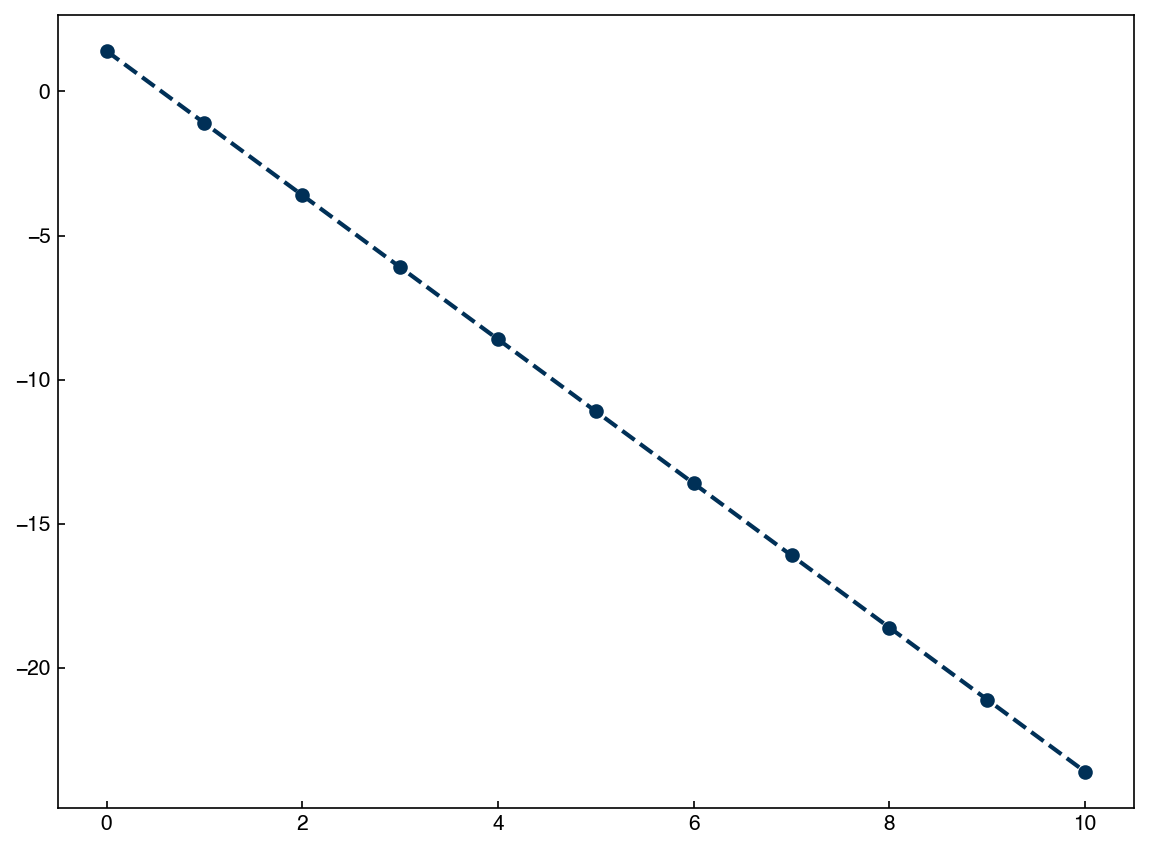

In [2]:
x = np.linspace(0,10,11)
x = x.reshape(-1, 1)  # make x into a column vector
w = [1.4, -2.5]

X = np.hstack((x**0, x))
y = X @ w

fig, ax = plt.subplots()
ax.plot(x, y, '--o');

We are still missing the $\epsilon$ term. This is the error, and in linear regression we assume that the error follows a normal distribution. We can generate a vector of normally-distributed noise using NumPy and add it to $\vec{y}$:

In [3]:
from numpy.random import normal
epsilon = normal(0, 0.1, len(x))

```{note}
The error term is modeled as normally distributed noise with mean 0 because we assume the model captures the true underlying trend, and the remaining differences are unbiased random variation. This is a standard assumption in statistical modeling and helps ensure that parameter estimates are not systematically biased.
```

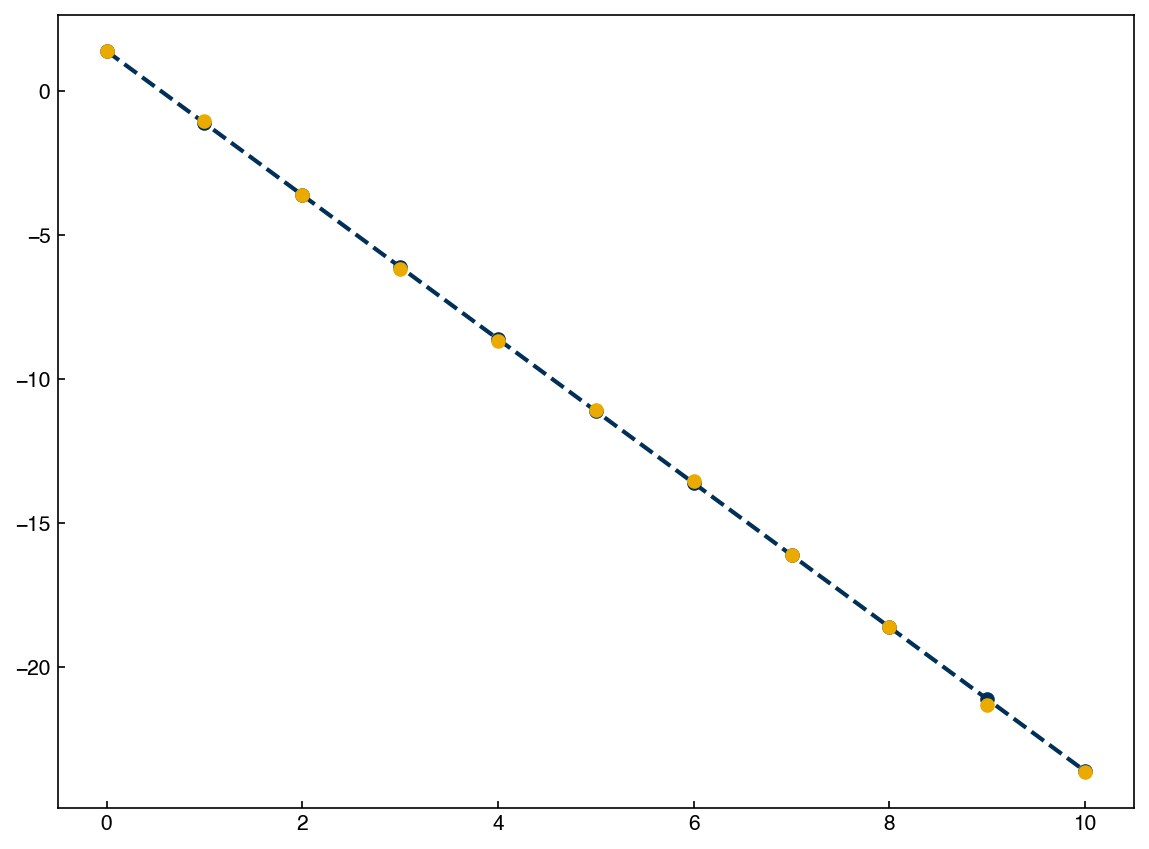

In [4]:
fig, ax = plt.subplots()
ax.plot(x, y, '--o')
y = y + epsilon
ax.plot(x, y, 'o');

The goal of linear regression is to use the data, $y_i$, to recover the best-fit line. In this case, we know the answer since we generated the data. However, we can also try to recover the line based only on the noisy data.

There are multiple ways to derive linear regression, but here we will derive it by minimizing the sum of squared errors. This is the origin of the name "least squares": we want to find the line that gives the lowest squared errors. First, we will set up a cost function that quantifies the squared errors:

$$
g = \sum_j \epsilon_j^2
$$

Next, we can recall the definition of an inner product to see that $\sum_j \epsilon_j^2 = \vec{\epsilon}^T \vec{\epsilon}$, so:

$$
g = \vec{\epsilon}^T \vec{\epsilon}.
$$

Next, we can re-arrange our expression for the model to solve for $\vec{\epsilon}$:

$$
\vec{y} = \bar{\bar{X}} \vec{w} + \vec{\epsilon}
\quad\Longrightarrow\quad
\vec{\epsilon} = \vec{y} - \bar{\bar{X}} \vec{w}
$$


Next we substitute this into the loss function

$$
g = \vec{\epsilon}^T \vec{\epsilon}
  = (\vec{y} - \bar{\bar{X}} \vec{w})^T (\vec{y} - \bar{\bar{X}} \vec{w})
$$

Recalling matrix transpose rules:

$$
(\vec{y} - \bar{\bar{X}} \vec{w})^T (\vec{y} - \bar{\bar{X}} \vec{w})
= (\vec{y}^T - \vec{w}^T \bar{\bar{X}}^T) (\vec{y} - \bar{\bar{X}} \vec{w})
$$

and multiplying:

$$
\vec{w}^T \bar{\bar{X}}^T \bar{\bar{X}} \vec{w}
- \vec{y}^T \bar{\bar{X}} \vec{w}
- \vec{w}^T \bar{\bar{X}}^T \vec{y}
+ \vec{y}^T \vec{y}
$$

the middle two terms are both dot products of $\vec{y}^T(\bar{\bar{X}}\vec{w})$ or $(\bar{\bar{X}}\vec{w})^T \vec{y}$, which are transposes of each other, and scalar quantities. The transpose of a scalar is equal to the same scalar, so these terms are equal and can be combined giving:

$$
g = \vec{w}^T \bar{\bar{X}}^T \bar{\bar{X}} \vec{w}
  - 2 \vec{y}^T \bar{\bar{X}} \vec{w}
  + \vec{y}^T \vec{y}
$$

---

```{note}
What is $g$ a function of? Although $x$ and $y$ are commonly treated as variables in engineering, here they are fixed data inputs. The only true variable in the loss function $g(\vec{w})$ is $\vec{w}$ — the vector of unknown parameters we want to optimize. This distinction is important when taking derivatives: we differentiate with respect to $\vec{w}$, holding $\vec{y}$ and $\bar{\bar{X}}$ constant.
```

---

We now have the sum of squared errors quantified as a function of the weights, $\vec{w}$:

$$
g(\vec{w})
= \vec{w}^T \bar{\bar{X}}^T \bar{\bar{X}} \vec{w}
- 2 \vec{y}^T \bar{\bar{X}} \vec{w}
+ \vec{y}^T \vec{y}
$$

Now we can recall the definition of minima from calculus: the derivative of a function at a minimum (or maximum) is 0. This implies that we need to take the derivative of the loss function with respect to the parameters $\vec{w}$ and set it equal to zero:

$$
\frac{\partial g}{\partial \vec{w}} = 0
$$

Taking derivatives with respect to vectors can be tricky, but the following two identities are useful:

$$
\frac{\partial (\bar{\bar{A}} \vec{x})}{\partial \vec{x}} = \bar{\bar{A}}^T
\qquad
\frac{\partial (\vec{x}^T \bar{\bar{A}} \vec{x})}{\partial \vec{x}}
= (\bar{\bar{A}}^T + \bar{\bar{A}})\vec{x}
$$

Using these identities you should be able to show that:

$$
\frac{\partial g}{\partial \vec{w}}
= 2 \bar{\bar{X}}^T \bar{\bar{X}} \vec{w}
- 2 \bar{\bar{X}}^T \vec{y}
$$

Setting equal to zero and re-arranging gives:

$$
\bar{\bar{X}}^T \bar{\bar{X}} \vec{w} = \bar{\bar{X}}^T \vec{y}
$$

Now we can notice that $\bar{\bar{X}}^T \bar{\bar{X}}$ is a matrix, which we can call $\bar{\bar{A}}$, and $\bar{\bar{X}}^T \vec{y}$ is a vector, which we can call $\vec{b}$. If we let $\vec{w} = \vec{x}$ then we can see that this is a system of linear equations:

$$
\bar{\bar{A}} \vec{x} = \vec{b}
$$

---

Let's set this up in Python for our toy problem:

In [5]:
A = X.T @ X
b = X.T @ y
w_lsr = np.linalg.solve(A, b)
print(f"Weights from least-squares regression: {w_lsr}")
print(f"Original weights to generate data: {w}")

Weights from least-squares regression: [ 1.42744455 -2.50869849]
Original weights to generate data: [1.4, -2.5]


We see that the results are not identical but are close. We can also check the quality of the best-fit line visually:

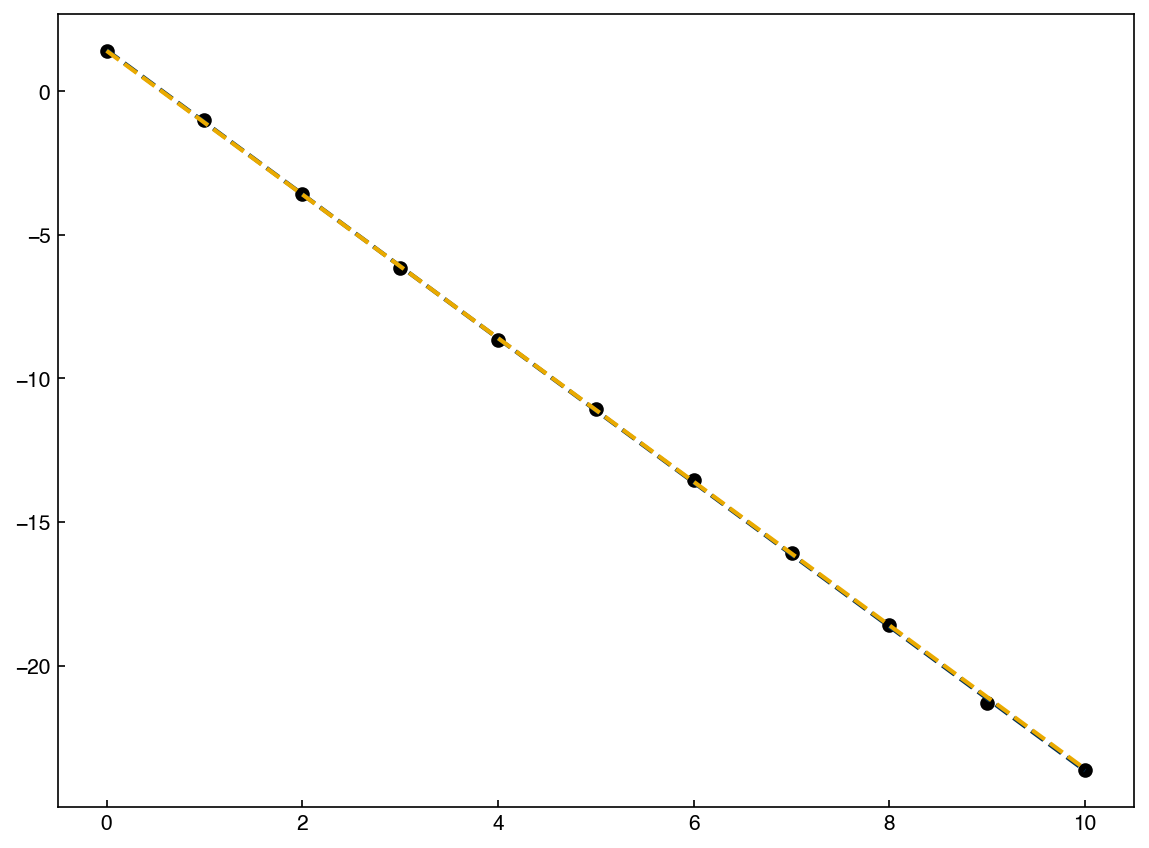

In [6]:
yhat = X @ w_lsr

fig, ax = plt.subplots()
ax.plot(x, y, 'ok')
ax.plot(x, yhat, '--')
ax.plot(x, X @ w, '--');

We can see that the best-fit line actually fits the data better than the original weights! We will explore more strategies for quantifying the fit in the "regression" lecture.

~~~{admonition} Exercise
:class: tip

Modify the code so that the true slope and intercept used to generate the data can be changed. Try adjusting the slope, intercept, and noise level, and observe how this affects the quality of the fit. Can you find a situation where the regression fails to recover the original model?
~~~

## Polynomial Regression

If you have seen simple linear regression before, the derivation above probably seemed far more complex than what you have seen in the past. However, the advantage is that it is also much more general, as we will see when moving to polynomial regression.

In polynomial regression, we expand the model to be of the form:

$$
y_i = w_0 + w_1 x_i + w_2 x_i^2 + w_3 x_i^3 + \dots + \epsilon_i
$$

As before, we can write this in summation notation:

$$
y_i = \sum_{j=0}^m w_j x_i^{j} + \epsilon_i
$$

where $m$ is the order of the highest polynomial. Recalling the definition of the Vandermonde matrix, we see that this can also be written as:

$$
\vec{y} = \bar{\bar{X}} \vec{w} + \vec{\epsilon}
$$

which is identical to the form that we used for linear regression. The only difference is that now the matrix $\bar{\bar{X}}$ has $m+1$ columns instead of 2 columns. This means that we can use the same solution from linear regression for polynomial regression!

$$
\bar{\bar{X}}^T \bar{\bar{X}} \vec{w} = \bar{\bar{X}}^T \vec{y}
$$

Let's see an example. First, we can generate some data:

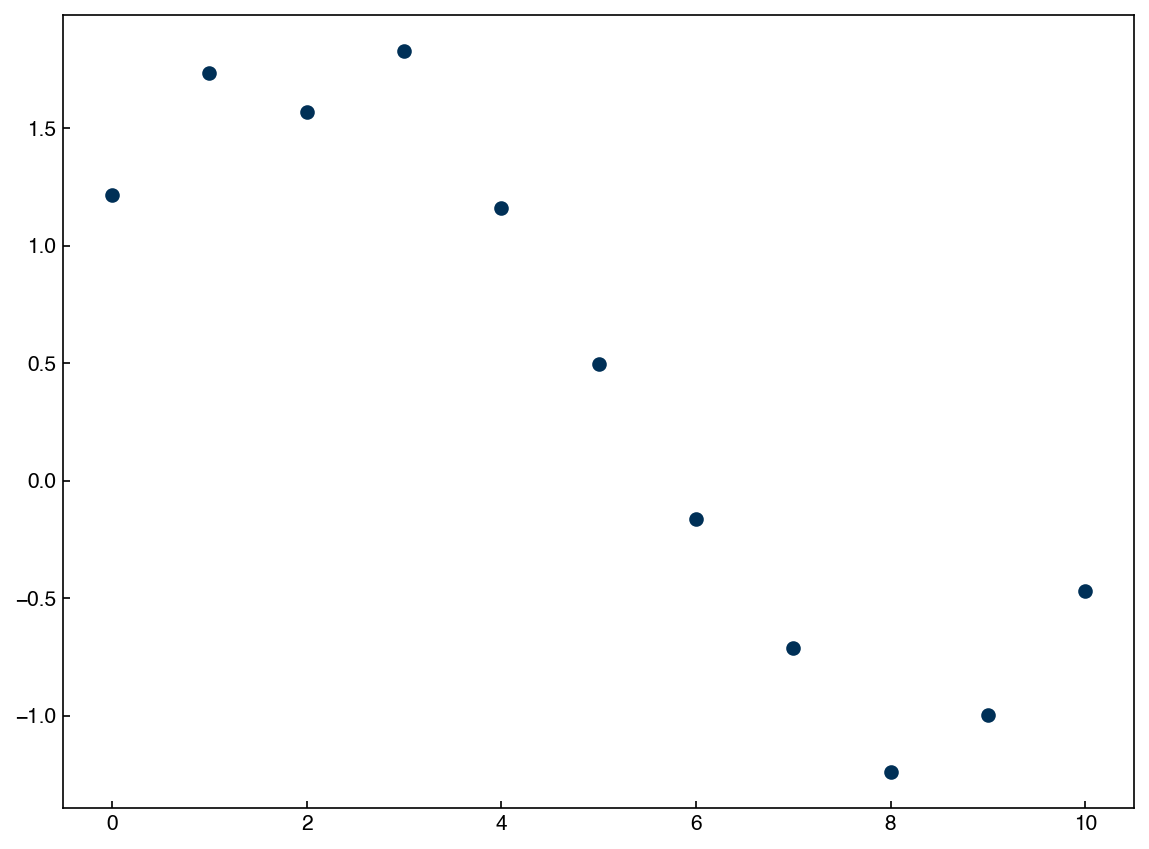

In [7]:
x = np.linspace(0,10,11)
x = x.reshape(-1, 1) #make x into a column vector
w = [1.4, 0.8, -0.3, 0.02]

X = np.hstack((x**0, x, x**2, x**3))
epsilon = normal(0, 0.2, len(x))
y = X@w + epsilon

fig, ax = plt.subplots()
ax.plot(x,y,'o');

Now we can try to recover the weights, $w$ using the same math as before:

In [8]:
A = X.T@X
b = X.T@y
w_lsr = np.linalg.solve(A,b)
print('Weights from least-squares regression: {}'.format(w_lsr))
print('Original weights to generate data: {}'.format(w))

Weights from least-squares regression: [ 1.13100455  0.91469945 -0.31120658  0.02033033]
Original weights to generate data: [1.4, 0.8, -0.3, 0.02]


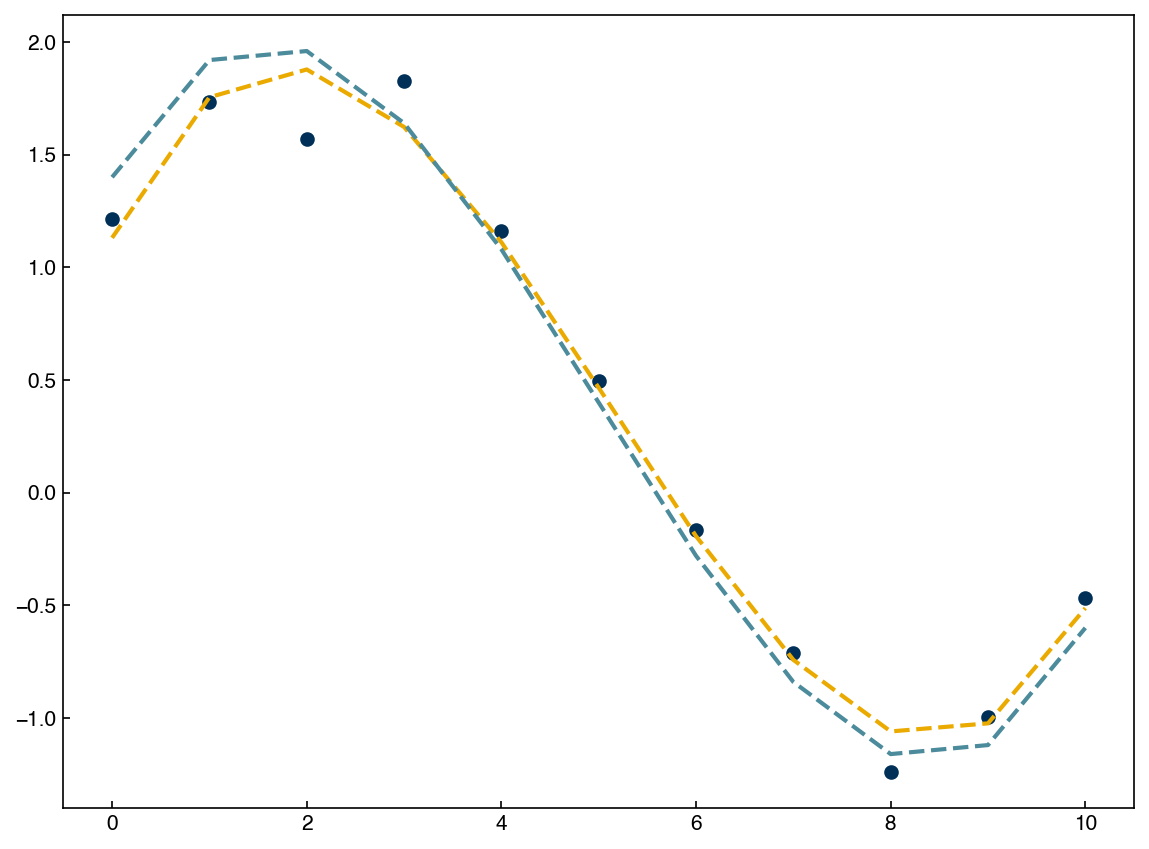

In [9]:
yhat = X@w_lsr

fig, ax = plt.subplots()
ax.plot(x, y, 'o')
ax.plot(x, yhat, '--')
ax.plot(x, X@w, '--');

In this case we cheated a bit, since we knew that the data was generated from a third-order polynomial. We can also find fits based on lower (or higher) orders of polynomials by modifying the order of the Vandermonde matrix used in the least-squares equation. First, we can make a function that creates a Vandermonde matrix of any order:

In [10]:
def vandermonde(x, order):
    cols = []
    for i in range(order):
        cols.append(x**i)
    return np.hstack(cols)

X_vdm = vandermonde(x,4)
X_vdm

array([[   1.,    0.,    0.,    0.],
       [   1.,    1.,    1.,    1.],
       [   1.,    2.,    4.,    8.],
       [   1.,    3.,    9.,   27.],
       [   1.,    4.,   16.,   64.],
       [   1.,    5.,   25.,  125.],
       [   1.,    6.,   36.,  216.],
       [   1.,    7.,   49.,  343.],
       [   1.,    8.,   64.,  512.],
       [   1.,    9.,   81.,  729.],
       [   1.,   10.,  100., 1000.]])

Now we can repeat the fitting procedure with different orders:

Weights: [ 1.21716365e+00  3.70723072e+00 -6.56580521e+00  4.85114381e+00
 -1.82140647e+00  3.76125525e-01 -4.34511188e-02  2.63503848e-03
 -6.53107619e-05]
Sum of Squared Errors (g): 0.02055183895251995


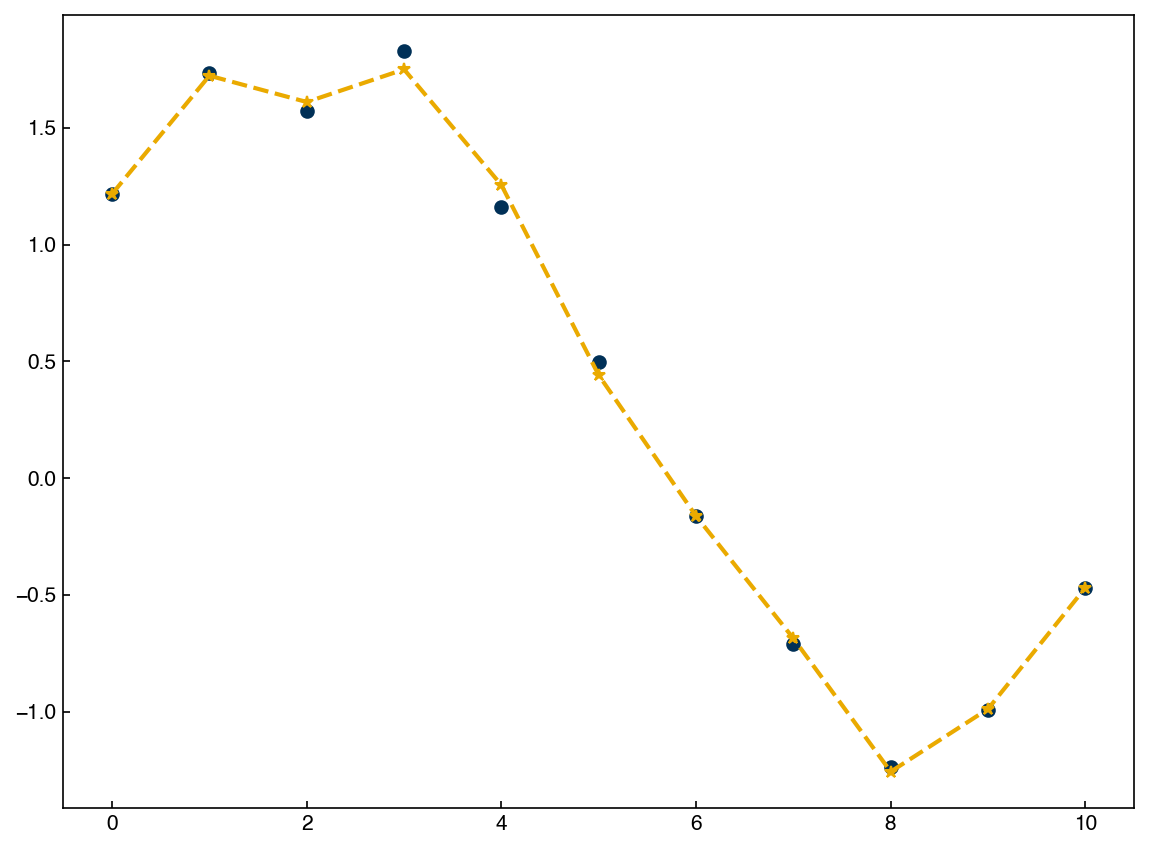

In [11]:
order = 9
X_vdm = vandermonde(x, order)
A = X_vdm.T@X_vdm
b = X_vdm.T@y
w_lsr = np.linalg.solve(A,b)

print('Weights: {}'.format(w_lsr))

yhat = X_vdm@w_lsr
SSE = sum((y - yhat)**2)
print('Sum of Squared Errors (g): {}'.format(SSE))

fig, ax = plt.subplots()
ax.plot(x, y, 'o')
ax.plot(x, yhat, '--*');

We see that as the order of the polynomial increases, the sum of squared errors decreases. However, we are only checking the behavior of our model at the points we use to train it. We can also use the model to interpolate between points or extrapolate to new points by creating a new Vandermonde matrix with more rows. Increasing the resolution adds rows within the original range, and results in interpolation, while increasing the range will result in extrapolation. Let's try both:

In [12]:
x_new = np.linspace(-1, 11, 100)
x_new = x_new.reshape(-1, 1) #create column vector
x_new.shape

(100, 1)

In [13]:
X_vdm_new = vandermonde(x_new, order)
X_vdm_new.shape

(100, 9)

We can create a new dataset based on this new higher resolution data:

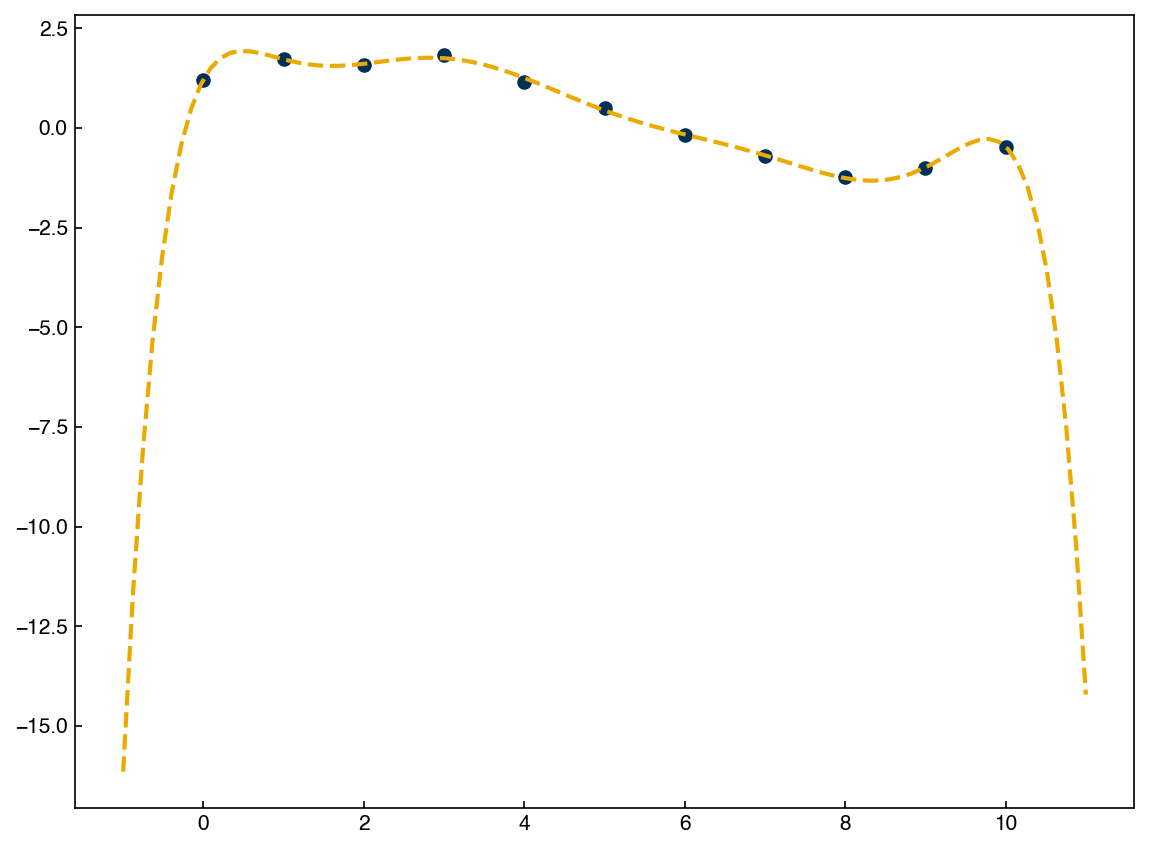

In [14]:
yhat_new = X_vdm_new@w_lsr

fig, ax = plt.subplots()
ax.plot(x, y, 'o')
ax.plot(x_new, yhat_new, '--');

We will discuss more techniques for validating the model and assessing the best order of the polynomial in future lectures.

```{admonition} Exercise
:class: tip

Try setting `order = 1`, `order = 3`, and `order = 15` in the Vandermonde matrix. Use the same `x_new` vector to interpolate and extrapolate. Plot the predictions and observe how the fit changes inside vs. outside the training data range.
```


## General Linear Regression

We just saw that a model of the form: 

$\vec{y} = \bar{\bar{X}}\vec{w} + \vec{\epsilon}$

can be used for simple linear regression (if $\bar{\bar{X}}$ is a first-order Vandermonde matrix) or polynomial regression (if $\bar{\bar{X}$ is a higher-order Vandermonde matrix). In fact, this form can be used for many different types of linear regression and is referred to as a **general linear model**. Note that this is different from a *generalized linear model*, where the error term is assumed to follow a distribution other than normal. This is very confusing, but not terribly relevant in practice.

The key concept is that the columns of $\bar{\bar{X}}$ can contain any type(s) of linearly-dependent non-linear functions and the math will remain the same:

$\bar{\bar{X}}^T\bar{\bar{X}}\vec{w^*} = \bar{\bar{X}}^T\vec{y}$

where $\vec{w^*}$ are the optimal least-squares parameters.

We will call the columns of $\bar{\bar{X}}$ the "basis functions" for general linear regression. One common technique is the use of Gaussians as the basis functions. We can demonstrate this with a more realistic dataset. We will load in a dataset from infrared spectroscopy of an ethanol molecule.

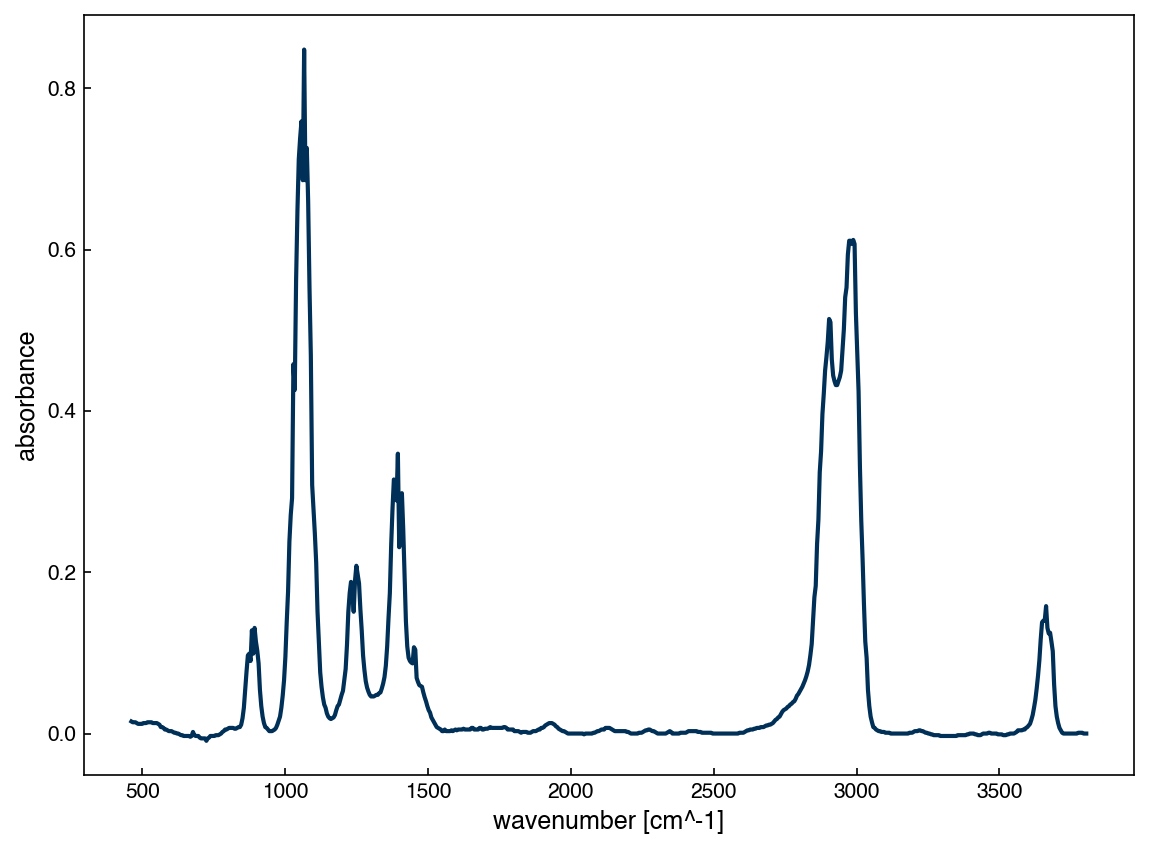

In [15]:
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv('data/ethanol_IR.csv')
x_all = df['wavenumber [cm^-1]'].values
y_all = df['absorbance'].values

fig, ax = plt.subplots()
ax.plot(x_all, y_all)
ax.set_xlabel('wavenumber [cm^-1]')
ax.set_ylabel('absorbance');

This data looks a lot more complicated than our toy dataset from before. Let’s make things easier by just selecting one of the peaks:

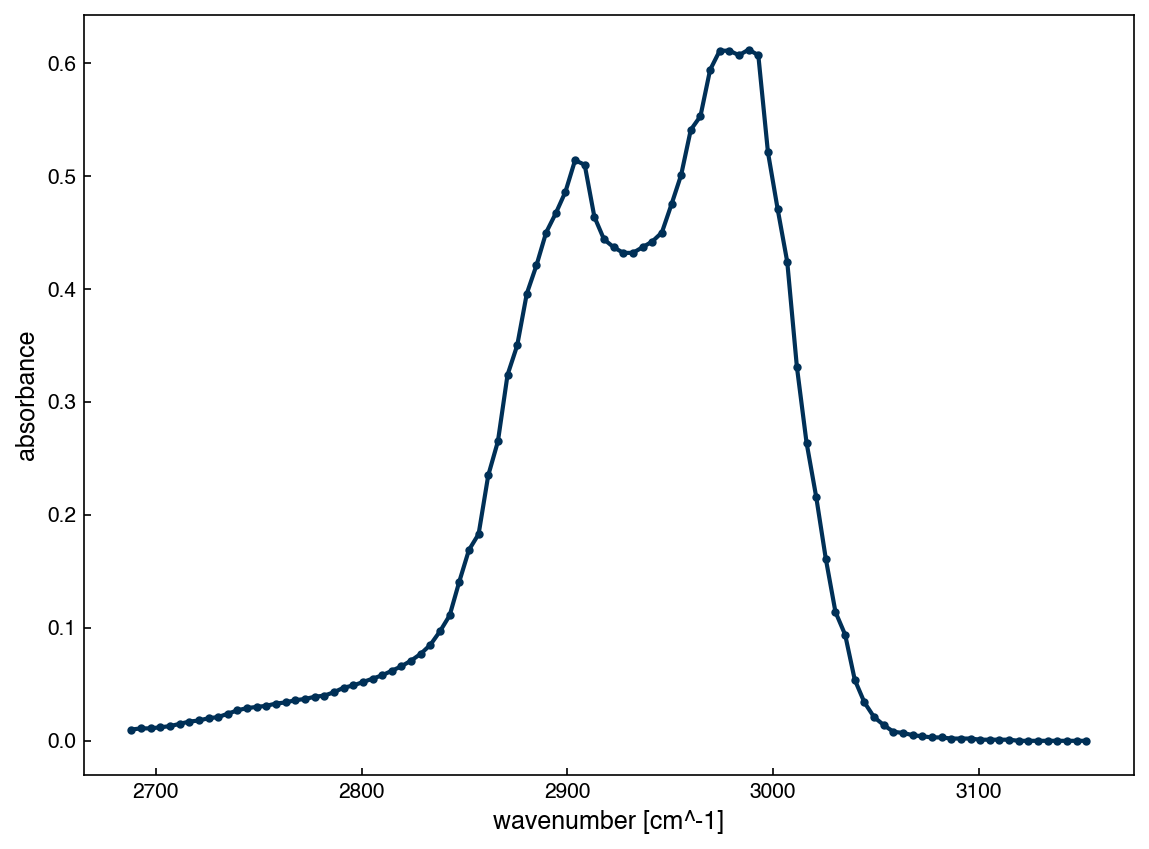

In [16]:
x_peak = x_all[475:575]
y_peak = y_all[475:575]

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, '-', marker='.')
ax.set_xlabel('wavenumber [cm^-1]')
ax.set_ylabel('absorbance');

Let's try fitting this with two manually placed Gaussians:

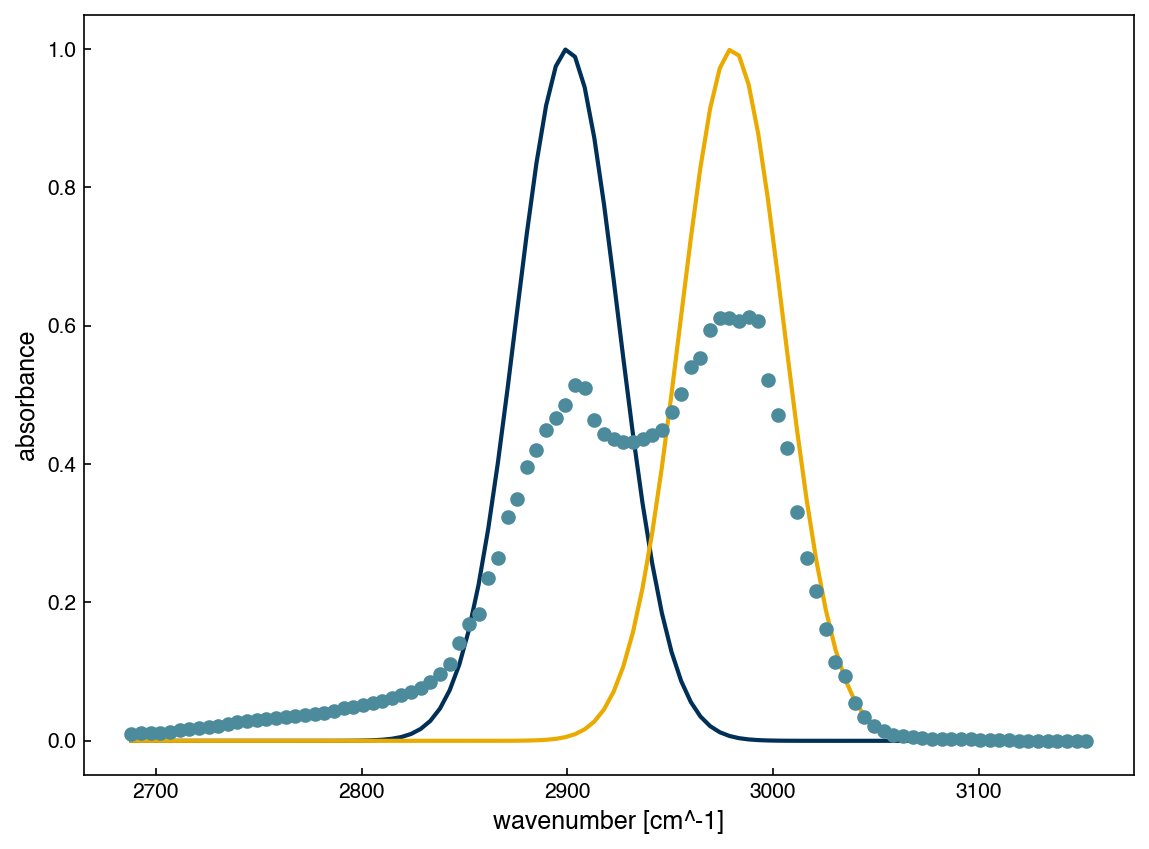

In [17]:
x_peak = x_peak.reshape(-1) #convert x_peak into a vector
X_gauss = np.zeros((len(x_peak), 2))
X_gauss[:,0] = np.exp(-(x_peak - 2900)**2/(2*(25**2)))
X_gauss[:,1] = np.exp(-(x_peak - 2980)**2/(2*(25**2)))

fig, ax = plt.subplots()
ax.plot(x_peak, X_gauss[:,0])
ax.plot(x_peak, X_gauss[:,1])
ax.plot(x_peak, y_peak, 'o')
ax.set_xlabel('wavenumber [cm^-1]')
ax.set_ylabel('absorbance');

Weights from least-squares regression: [0.54548962 0.67533912]


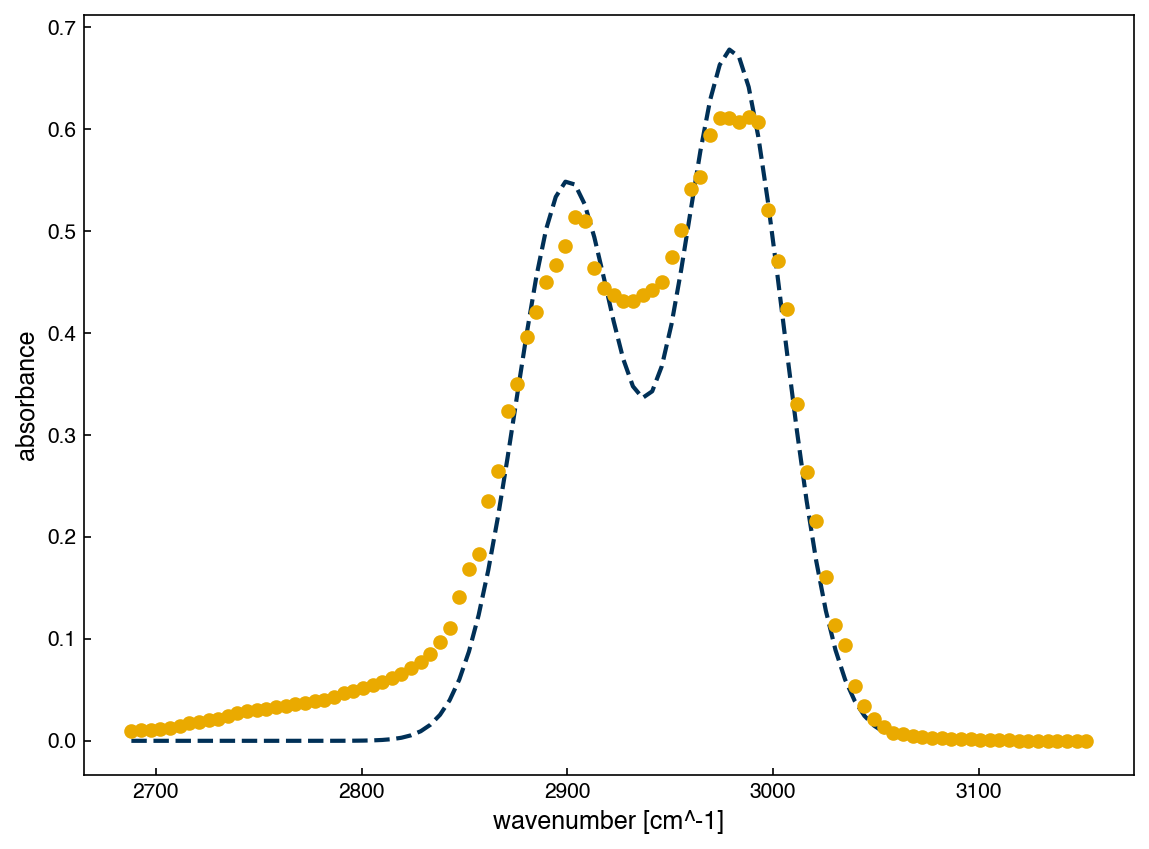

In [18]:
A = X_gauss.T @ X_gauss
b = X_gauss.T @ y_peak
w_lsr = np.linalg.solve(A, b)
yhat = X_gauss @ w_lsr
print('Weights from least-squares regression: {}'.format(w_lsr))

fig, ax = plt.subplots()
ax.plot(x_peak, yhat, '--')
ax.plot(x_peak, y_peak, 'o')
ax.set_xlabel('wavenumber [cm^-1]')
ax.set_ylabel('absorbance');

This looks much better than the polynomial fit, and we only needed 2 parameters! But we still had to guess the peak positions and widths.

Let’s automate this using a more general method.

In [19]:
def gaussian_features(x, N, sigma=25):
    x = x.reshape(-1)
    xk_vec = np.linspace(min(x), max(x), N)
    features = []
    for xk in xk_vec:
        features.append(np.exp(-((x - xk)**2)/(2*sigma**2)))
    return np.array(features).T

Use this to fit the spectrum:

Weights: [ 0.00618991  0.01283186  0.02895143  0.02964597  0.08421234  0.42542746
  0.18814892  0.574715    0.02757571 -0.00945447  0.00639036 -0.00400029]
Sum of Squared Errors: 0.007590570362196521


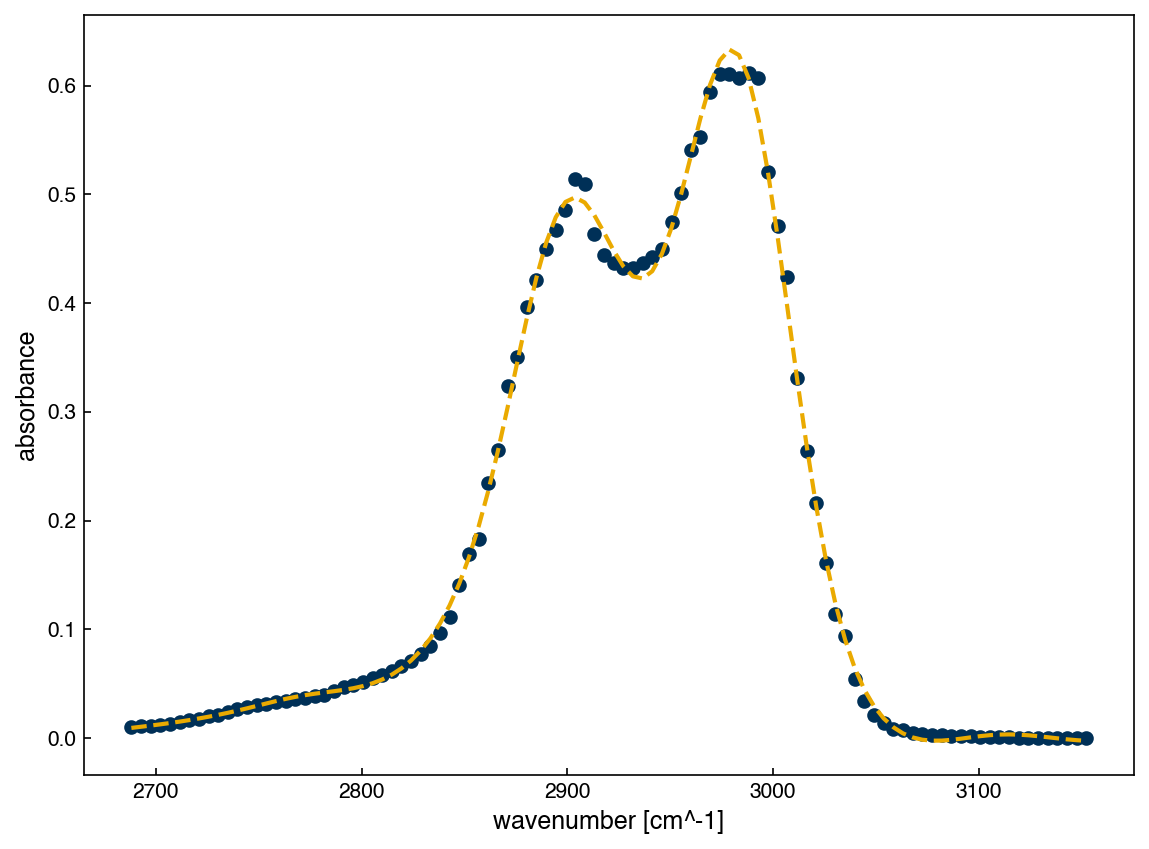

In [20]:
m = 12

X_gauss = gaussian_features(x_peak, m) #generate features
A_m = X_gauss.T @ X_gauss
b_m = X_gauss.T @ y_peak
w_m = np.linalg.solve(A_m, b_m)

yhat_m = X_gauss @ w_m
SSE_m = np.sum((y_peak - yhat_m)**2)

print('Weights: {}'.format(w_m))
print('Sum of Squared Errors: {}'.format(SSE_m))

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, 'o')
ax.plot(x_peak, yhat_m, '--')
ax.set_xlabel('wavenumber [cm^-1]')
ax.set_ylabel('absorbance');

This model now uses 12 Gaussian basis functions spaced evenly across the selected region of the spectrum. Each basis function captures a portion of the absorbance profile, and the regression coefficients determine how much each feature contributes to the total fit.

By solving the least squares problem for this set of features, we are able to approximate the shape of the spectrum quite accurately. The peaks are reconstructed not by guessing their locations, but by allowing the model to find an optimal combination of these fixed-width features.

The number of features (`m`) and the width of the Gaussian peaks (`sigma`) both influence how flexible the model is. If `sigma` is too large, peaks may blur together; if it is too small, the fit may become noisy and sensitive to small variations in the data.

```{note}
This modeling approach resembles traditional spectral peak fitting but should be interpreted differently. In typical spectroscopy, positive peak heights reflect physical quantities. Here, negative weights are allowed and may appear, not because of physical meaning, but because the model optimizes a numerical error. The goal is best fit, not physical interpretability.
```

```{admonition} Exercise
:class: tip

Try modifying the `sigma` parameter in the `gaussian_features` function. How does increasing or decreasing the width affect the fit? Try values of 10, 25, and 50, and observe which features are emphasized or smoothed out.
```


## Linear Regression in Scikit-Learn

So far we have solved our general linear regression models directly from linear algebra. This is relatively easy, but it still requires us to set up a linear system and solve it. There is a very useful Python package called `scikit-learn` that has implementations of many commonly-used algorithms, including general linear models. 

We will introduce `scikit-learn` here to show how it can make things simpler. One thing to note is that `scikit-learn` only solves the regression part of the problem, so we still need to set up the feature matrix, $X_{ij}$. We will keep working with the spectra example, and use the `gaussian_features` function that we wrote earlier:

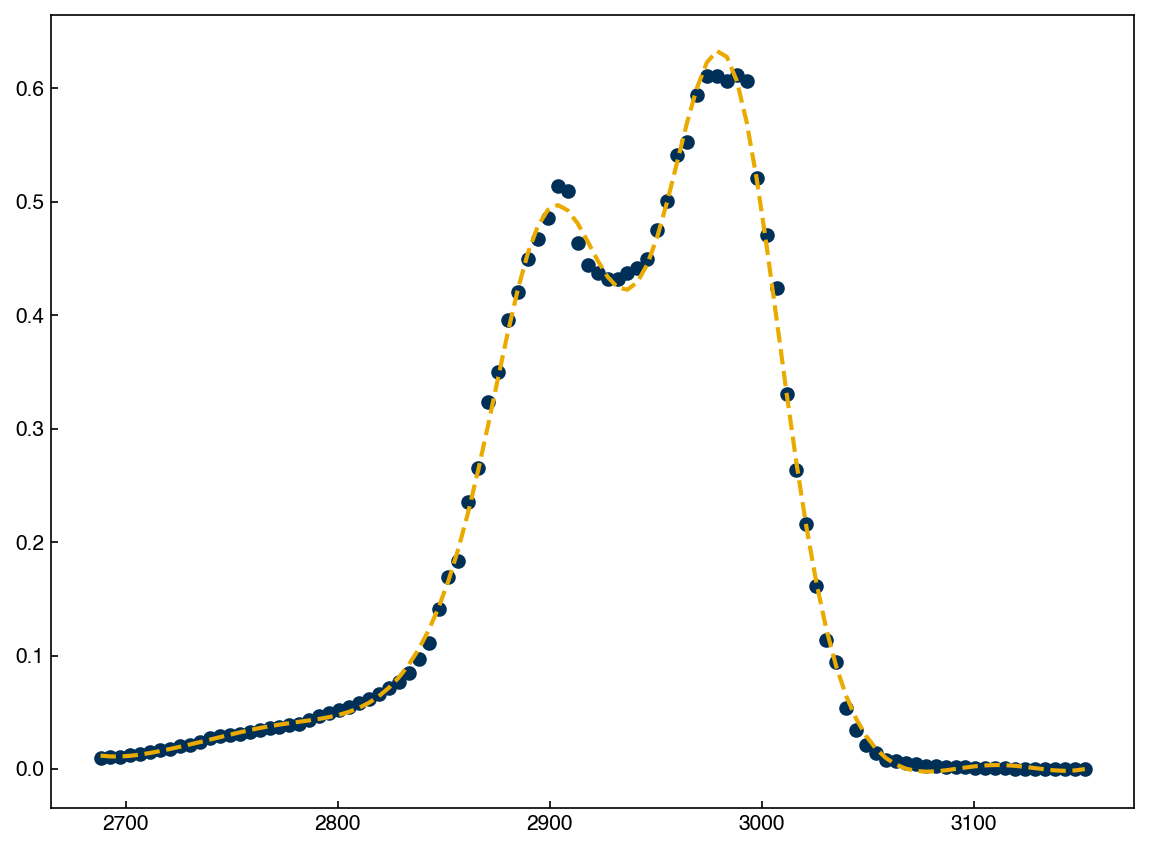

In [21]:
from sklearn.linear_model import LinearRegression

m = 12

X_m = gaussian_features(x_peak, m, sigma=25) #generate features

model = LinearRegression() #create a linear regression model instance

model.fit(X_m, y_peak) #fit the model (equivalent to the linear solve)

yhat = model.predict(X_m) #create the model prediction (equivalent to the matrix multiplication)

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, 'o')
ax.plot(x_peak, yhat, '--');

We can see that this requires much less code. However, `scikit-learn` is heavily "object" or "class" based, which can make the syntax confusing if you aren't familiar with Python. The advantage is that it is very easy to change the model and compare performance, as we will see in future lectures.


The key takeaway is that `scikit-learn` abstracts away the manual matrix operations and provides a streamlined interface. This can save time and reduce coding errors, especially when using more complex models. However, it also means that we give up a bit of transparency — it’s important to understand what’s happening under the hood.

By using `fit()` and `predict()`, we are replicating the behavior of solving $\bar{X}^T\bar{X}\vec{w} = \bar{X}^T\vec{y}$ and then evaluating $\bar{X}\vec{w}$. The weights themselves can be accessed via `model.coef_`, and the intercept via `model.intercept_`.

In [22]:
print("Learned weights:", model.coef_)
print("Intercept:", model.intercept_)

Learned weights: [-0.02758914 -0.01444074 -0.00059751  0.00110594  0.05520992  0.39660691
  0.15932838  0.54571257 -0.00096432 -0.0390034  -0.02088223 -0.03777934]
Intercept: 0.04286995631699525


This is useful if you want to inspect the result or transfer the model elsewhere.


```{admonition} Exercise
:class: tip

Try increasing the number of Gaussian features `m` from 12 to 20 and observe how the fit changes. Does it improve? What happens if you reduce it to 5? Use `model.coef_` to inspect how many of the features have nonzero weight.
```



## Additional Reading

- [scikit-learn: Linear regression documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
- [Elements of Statistical Learning – Hastie, Tibshirani, Friedman](https://web.stanford.edu/~hastie/ElemStatLearn/)
- [Pattern Recognition and Machine Learning – Bishop, Chapter 3]
- [CS229 Lecture Notes on Linear Regression – Stanford](https://cs229.stanford.edu/notes2022fall/cs229-notes1.pdf)